# **SMART MEDIA TECHNOLOGY : REPRODUKTION VON KUNSTEPOCHEN**
This Colab Notebook is based on the VQGAN + CLIP Model from Katherine Crowson

https://github.com/nerdyrodent/VQGAN-CLIP 



<img width=600 src=https://user-images.githubusercontent.com/81929072/156060845-4921f394-3ae4-49f0-9273-e0dc5da6cbcd.png>



## 0 - DOWNLOAD
**Download** :  Wikiart_16384 & CLIP + VQGAN Models

In [ ]:
!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers.git
!pip install ray taming-transformers ftfy regex tqdm omegaconf pytorch-lightning kornia imageio-ffmpeg einops           
!wget -nc -O wikiart_16384.yaml http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml
!wget -nc -O wikiart_16384.ckpt http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt 
!mkdir steps

Cloning into 'CLIP'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 195 (delta 12), reused 22 (delta 9), pack-reused 168
Receiving objects: 100% (195/195), 8.91 MiB | 14.21 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (493/493), done.
remote: Total 1335 (delta 58), reused 481 (delta 30), pack-reused 810
Receiving objects: 100% (1335/1335), 412.35 MiB | 28.63 MiB/s, done.
Resolving deltas: 100% (267/267), done.
     |████████████████████████████████| 59.6 MB 1.2 MB/s 
     |████████████████████████████████| 45 kB 3.6 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 527 kB 47.8 MB/s 
     |█████████████████████████

--2022-02-26 19:34:35--  http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml
Resolving eaidata.bmk.sh (eaidata.bmk.sh)... 176.9.113.70
Connecting to eaidata.bmk.sh (eaidata.bmk.sh)|176.9.113.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 920 [application/octet-stream]
Saving to: ‘wikiart_16384.yaml’

wikiart_16384.yaml  100%[===================>]     920  --.-KB/s    in 0s      

2022-02-26 19:34:35 (101 MB/s) - ‘wikiart_16384.yaml’ saved [920/920]

--2022-02-26 19:34:35--  http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt
Resolving eaidata.bmk.sh (eaidata.bmk.sh)... 176.9.113.70
Connecting to eaidata.bmk.sh (eaidata.bmk.sh)|176.9.113.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1005327541 (959M) [application/octet-stream]
Saving to: ‘wikiart_16384.ckpt’

wikiart_16384.ckpt  100%[===================>] 958.75M  8.37MB/s    in 1m 57s  

2022-02-26 19:36:32 (8.20 MB/s) - ‘wikiart_16384.ck

## 1 - IMPORTS
**Import** : Required python libraries

In [ ]:
# Python
import argparse
import functools
import glob
import math
from pathlib import Path
import os
import os.path as osp
import sys

# PyTorch
import torch
from torch import nn, optim
import torch.nn as nn
from torch.nn import functional as F
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.tensorboard import SummaryWriter

# Various
from base64 import b64encode
from CLIP import clip
import cv2
from google.colab import drive
import imageio
from IPython import display
import kornia.augmentation as K
import numpy as np
from omegaconf import OmegaConf
from PIL import ImageFile, Image
from ray import tune
from ray.tune import schedulers
from taming.models import cond_transformer, vqgan
import taming.modules 
from tqdm.notebook import tqdm

## 2 - SETUP
**Setup** : Different functions and classes for CLIP & VQGAN

In [ ]:
sys.path.insert(1, '/content/taming-transformers')
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

In [ ]:
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)

In [ ]:
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

In [ ]:
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

In [ ]:
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.augs = nn.Sequential(
            # K.RandomHorizontalFlip(p=0.5),
            # K.RandomVerticalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            # K.RandomSharpness(0.3,p=0.4),
            # K.RandomResizedCrop(size=(self.cut_size,self.cut_size), scale=(0.1,1),  ratio=(0.75,1.333), cropping_mode='resample', p=0.5),
            # K.RandomCrop(size=(self.cut_size,self.cut_size), p=0.5),
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), same_on_batch=True, p=0.7),
            
)
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        
        for _ in range(self.cutn):

            # size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            # offsetx = torch.randint(0, sideX - size + 1, ())
            # offsety = torch.randint(0, sideY - size + 1, ())
            # cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            # cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

            # cutout = transforms.Resize(size=(self.cut_size, self.cut_size))(input)
            
            cutout = (self.av_pool(input) + self.max_pool(input))/2
            cutouts.append(cutout)
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch

In [ ]:
replace_grad = ReplaceGrad.apply
clamp_with_grad = ClampWithGrad.apply

## 3 - INTERACTIVE
**Interactive** : Parameter generation and picture generation

In [ ]:
#@markdown #**Parameters**
#@markdown ---

texts = "romanticism caspar david friedrich moon" #@param {type:"string"}
width =  300#@param {type:"number"}
height = 300#@param {type:"number"}
model = "wikiart_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "vqgan_openimages_f16_8192", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]
images_interval =  50#@param {type:"number"}
init_image = ""#@param {type:"string"}
target_images = ""#@param {type:"string"}
seed = -1#@param {type:"number"}
max_iterations = -1#@param {type:"number"}

model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 'vqgan_openimages_f16_8192':'OpenImages 8912',
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
name_model = model_names[model]     

if seed == -1:
    seed = None
if init_image == "None":
    init_image = None
if target_images == "None" or not target_images:
    target_images = []
else:
    target_images = target_images.split("|")
    target_images = [image.strip() for image in target_images]

texts = [phrase.strip() for phrase in texts.split("|")]
if texts == ['']:
    texts = []


args = argparse.Namespace(
    prompts=texts,
    image_prompts=target_images,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=init_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.1,
    cutn=32,
    cut_pow=1.,
    display_freq=images_interval,
    seed=seed,
)

Using device: cuda:0
Using texts: ['romanticism caspar david friedrich moon']
Using seed: 5175601051808889875
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 561kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from wikiart_16384.ckpt


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 105MiB/s]


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


i: 0, loss: 1.01535, losses: 1.01535


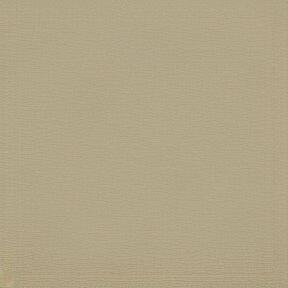

i: 50, loss: 0.84293, losses: 0.84293


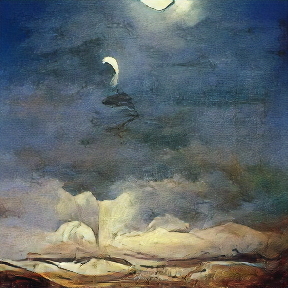

In [ ]:
#@markdown #**Fire up the AI**

#@markdown ---
from urllib.request import urlopen

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if texts:
    print('Using texts:', texts)
if target_images:
    print('Using image prompts:', target_images)
if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
# clock=deepcopy(perceptor.visual.positional_embedding.data)
# perceptor.visual.positional_embedding.data = clock/clock.max()
# perceptor.visual.positional_embedding.data=clamp_with_grad(clock,0,1)

cut_size = perceptor.visual.input_resolution

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f

if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
    e_dim = 256
    n_toks = model.quantize.n_embed
    z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
else:
    e_dim = model.quantize.e_dim
    n_toks = model.quantize.n_e
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
# z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
# z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

# normalize_imagenet = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                            std=[0.229, 0.224, 0.225])

if args.init_image:
    if 'http' in args.init_image:
      img = Image.open(urlopen(args.init_image))
    else:
      img = Image.open(args.init_image)
    pil_image = img.convert('RGB')
    pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
    pil_tensor = TF.to_tensor(pil_image)
    z, *_ = model.encode(pil_tensor.to(device).unsqueeze(0) * 2 - 1)
else:
    one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
    # z = one_hot @ model.quantize.embedding.weight
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z = one_hot @ model.quantize.embed.weight
    else:
        z = one_hot @ model.quantize.embedding.weight
    z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
    z = torch.rand_like(z)*2
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])



pMs = []

for prompt in args.prompts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for prompt in args.image_prompts:
    path, weight, stop = parse_prompt(prompt)
    img = Image.open(path)
    pil_image = img.convert('RGB')
    img = resize_image(pil_image, (sideX, sideY))
    batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
    embed = perceptor.encode_image(normalize(batch)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
    gen = torch.Generator().manual_seed(seed)
    embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
    pMs.append(Prompt(embed, weight).to(device))

def synth(z):
    if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
    else:
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)
    TF.to_pil_image(out[0].cpu()).save('progress.png')
    display.display(display.Image('progress.png'))

def ascend_txt():
    global i
    out = synth(z)
    iii = perceptor.encode_image(normalize(make_cutouts(out))).float()
    
    result = []

    if args.init_weight:
        # result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)
        result.append(F.mse_loss(z, torch.zeros_like(z_orig)) * ((1/torch.tensor(i*2 + 1))*args.init_weight) / 2)
    for prompt in pMs:
        result.append(prompt(iii))
    img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
    img = np.transpose(img, (1, 2, 0))
    imageio.imwrite('./steps/' + str(i) + '.png', np.array(img))

    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.display_freq == 0:
        checkin(i, lossAll)
       
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

i = 0
try:
    with tqdm() as pbar:
        while True:
            train(i)
            if i == max_iterations:
                break
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass